In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [2]:
# import era5 data 
# merge all together 
# clip by HMA regions (pick one) 
# find median pixel (location)
# go to GEE find the date of snowline in that location (average over pixel area maybe?)
# 

### hma regions

In [14]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 
# hma_df.columns
hma_df.Name

0             Eastern Hindu Kush
1               Western Himalaya
2               Eastern Himalaya
3               Central Himalaya
4                      Karakoram
5                  Western Pamir
6                     Pamir Alay
7     Northern/Western Tien Shan
8             Dzhungarsky Alatau
9            Western Kunlun Shan
10               Nyainqentanglha
11            Gangdise Mountains
12                 Hengduan Shan
13    Tibetan Interior Mountains
14                 Tanggula Shan
15     Eastern Tibetan Mountains
16                   Qilian Shan
17           Eastern Kunlun Shan
18                    Altun Shan
19             Eastern Tien Shan
20             Central Tien Shan
21                 Eastern Pamir
Name: Name, dtype: object

## era5

In [10]:
'''
# read:
t2m = xr.open_dataset('era5_2m-temperature_hourly_2012.nc', decode_coords="all")
ssrd = xr.open_dataset('era5_surface-solar-radiation-downwards_hourly_2012.nc', decode_coords="all")
tcc = xr.open_dataset('era5_total-cloud-cover_hourly_2012.nc', decode_coords="all")
tp = xr.open_dataset('era5_total-precipitation_hourly_2012.nc', decode_coords="all")

# merge by coordinates 
# tutorial: https://docs.xarray.dev/en/stable/user-guide/combining.html
climate = xr.merge([t2m, tp, ssrd, tcc]) 
'''

'\n# read:\nt2m = xr.open_dataset(\'era5_2m-temperature_hourly_2012.nc\', decode_coords="all")\nssrd = xr.open_dataset(\'era5_surface-solar-radiation-downwards_hourly_2012.nc\', decode_coords="all")\ntcc = xr.open_dataset(\'era5_total-cloud-cover_hourly_2012.nc\', decode_coords="all")\ntp = xr.open_dataset(\'era5_total-precipitation_hourly_2012.nc\', decode_coords="all")\n\n# merge by coordinates \n# tutorial: https://docs.xarray.dev/en/stable/user-guide/combining.html\nclimate = xr.merge([t2m, tp, ssrd, tcc]) \n'

### OR: era5 open all 

In [11]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600

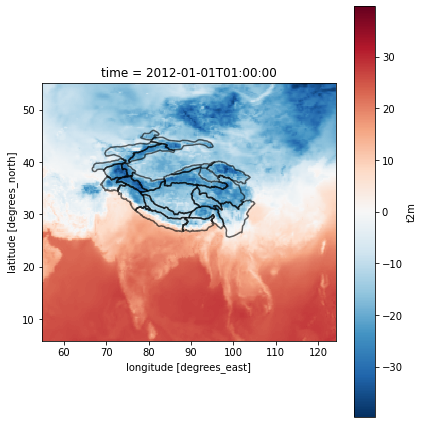

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
climate.t2m[1,:,:].plot()#palette='viridis')
hma.boundary.plot(ax=ax, alpha=.6, color='black')
fig.tight_layout()

In [15]:
''' change name of the mountain range here'''

roi = hma[hma['Name'] == 'Karakoram']
name = roi.Name
# karakoram.crs

# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_climate = climate.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

In [16]:
# plot the selected shp 

# roi.boundary.plot()
# fig.tight_layout()

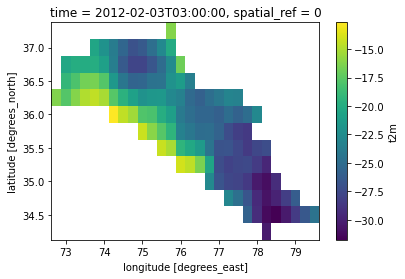

In [17]:
# see how it looks like 
roi_climate.t2m[795,:,:].plot()
fig.tight_layout()

In [18]:
# calculate how many era5 pix fall into the mountain range polygon

x = roi_climate.t2m[795,:,:].values.flatten()
x_count = roi_climate.t2m.median(dim='time').values.flatten().shape
print('total numnber of pixels within bbox:', x_count)

# without nans
x2 = x[~np.isnan(x)]
print('number of not-nan pixels:', x2.shape)


total numnber of pixels within bbox: (364,)
number of not-nan pixels: (132,)


/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [22]:
# check for the median: 
if (len(x2) % 2) == 0:
    print ('EVEN number of not-nans -> ceiling/floor median')
else:print ('ODD number of not-nans -> regular median is ok')

EVEN number of not-nans -> ceiling/floor median


### time dimention (-> value IN TIME)

In [23]:
## "flatten" the data over time: reduce to smth (median temperatures/sum of precipitation over the year/etc) 

# statistics + keep the coordinates -> value IN TIME 
roi_climate_median = roi_climate.median(dim='time', keep_attrs = True, skipna=True)
roi_climate_sum = roi_climate.sum(dim='time', keep_attrs = True)


### space dimention (with pandas)

In [24]:
# with pandas: 
# (1) compute median in time (-> on the previous step) 
# (2) convert to dataframe (with coords being index)
# (3) kick out nans and duplicates
# (4) compute median (or some other thing) across the table 
# (5) find the index of the value that eq=median


# to dataframe - median:
roi_climate_median_df = roi_climate_median.to_dataframe() # dimentions: number of catchments squared
roi_climate_median_df = roi_climate_median_df.dropna()
roi_climate_median_df = roi_climate_median_df.drop_duplicates()
# sanity check:
print('length of the df:', len(roi_climate_median_df))

# to dataframe - sum:
roi_climate_sum_df = roi_climate_sum.to_dataframe() # dimentions: number of catchments squared
roi_climate_sum_df = roi_climate_sum_df.dropna()
roi_climate_sum_df = roi_climate_sum_df.drop_duplicates()


 
roi_climate_median_df.head()

/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


length of the df: 132


spatial_ref       ssrd        t2m       tcc        tp
latitude longitude                                                       
37.25    75.75                0  12.961145  -6.446304  0.569637  0.002127
37.00    73.75                0  14.725625 -12.537872  0.820152  0.005309
         74.00                0  14.975069 -13.703293  0.861246  0.004247
         74.25                0  16.868889 -15.213623  0.813224  0.004247
         74.50                0  16.129826 -15.028030  0.811637  0.004247

### median value of the not-nan pixels: 

In [143]:
# since there are even number of pixels calculate medians in space this way: 

def median_ceil(values):
    values = sorted(values)
    values_len = len(values)
    middle = values_len//2
    return values[middle]

# t2m: 
t2m_median = roi_climate_median_df[roi_climate_median_df.t2m==median_ceil(values=roi_climate_median_df.t2m)]
tp_median = roi_climate_median_df[roi_climate_median_df.tp==median_ceil(values=roi_climate_median_df.tp)]

print('coordinates for the median temperature:', t2m_median.index) # 34.5, 78.5

print('coordinates for the median precipitation:', tp_median.index) # more then one 

coordinates for the median temperature: MultiIndex([(34.5, 78.5)],
           names=['latitude', 'longitude'])
coordinates for the median precipitation: MultiIndex([( 37.0, 74.75),
            ( 37.0,  75.0),
            (36.75, 73.25),
            (36.75,  73.5),
            (36.75, 73.75),
            ( 36.5, 73.25),
            ( 36.5,  73.5),
            (36.25,  74.5),
            ( 36.0, 76.75),
            ( 35.5,  76.0),
            ( 34.5,  78.5)],
           names=['latitude', 'longitude'])


In [139]:
# go to gee and find images for the may snow line (snow presistence) 
# Snow persistence is defined as the fraction of time that a grid cell is covered by snow. 


In [28]:
# roi_climate
# lon - 72
# lat - 37

### Get time-series of the temperature median

In [32]:
# select data 
ts = roi_climate.sel(longitude = 78.5, latitude = 34.5, method = 'nearest')
# convert to df
ts_df = ts.to_dataframe()

In [33]:
ts_df.head()

,latitude,longitude,spatial_ref,ssrd,t2m,tcc,tp
time,,,,,,,
2012-01-01 00:00:00,34.5,78.5,0,0.000000,-30.746857,0.752659,0.012740
2012-01-01 01:00:00,34.5,78.5,0,0.000000,-30.406586,0.878534,0.006370
2012-01-01 02:00:00,34.5,78.5,0,0.110833,-30.139023,0.811927,0.004247
2012-01-01 03:00:00,34.5,78.5,0,70.764343,-33.933014,0.730228,0.004247
2012-01-01 04:00:00,34.5,78.5,0,258.077301,-32.029053,0.921108,0.003189


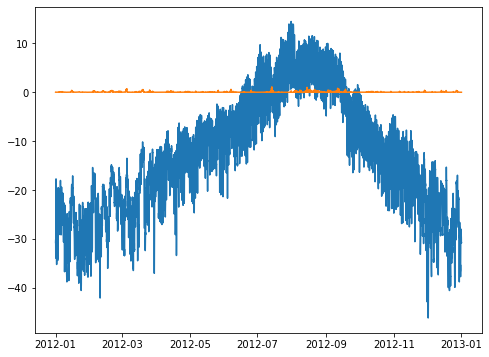

In [42]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(ts_df.t2m)
ax.plot(ts_df.tp)
# ax2.plot(df.time, df.tcc, 'b-')ts_df.t2m.plot()

Text(0, 0.5, 'tp')

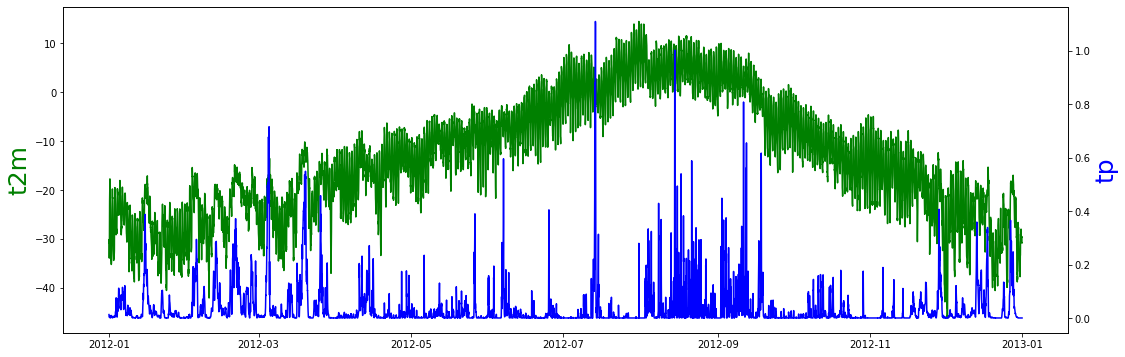

In [51]:
fig, ax1 = plt.subplots(figsize = (18,6))

ax2 = ax1.twinx()

ax1.plot(ts_df.t2m, 'g-')
ax2.plot(ts_df.tp, 'b-')

ax1.set_ylabel('t2m', color='g', fontsize = 25)
ax2.set_ylabel('tp', color='b', fontsize = 25)

### xr.where() - way
#### spatial dimention (-> value IN SPACE + find location ) 

In [ ]:
# calculate the median value over the region -> vallue IN SPACE 
# then find it's location 
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.where.html

# roi_t2m_median = roi_climate_median.t2m.median()#dim = axes, keep_attrs = True)


In [55]:
# with numpy (for T2M and TP): 

# t2m median vallue

median_t2m = roi_climate_median.t2m.values.flatten()
# without nans
median_t2m = np.median(median_t2m[~np.isnan(median_t2m)])
print('median_t2m value:', median_t2m)

median_t2m_where = roi_climate_median.t2m.where(roi_climate_median.t2m == median_t2m)
# print('median_t2m_where - location of the median vallue:', median_t2m_where)

median_t2m value: 259.59478759765625
median_t2m_where - location of the median vallue: <xarray.DataArray 't2m' (latitude: 13, longitude: 28)>
dask.array<where, shape=(13, 28), dtype=float32, chunksize=(13, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 37.25 37.0 36.75 36.5 ... 34.75 34.5 34.25
  * longitude    (longitude) float64 72.75 73.0 73.25 73.5 ... 79.0 79.25 79.5
    spatial_ref  int64 0
Attributes:
    units:      K
    long_name:  2 metre temperature


In [76]:
# type(roi_climate_median)
# type(median_t2m)
# ds

In [73]:
ds = roi_climate_median.where(roi_climate_median.t2m == median_t2m, )

In [77]:
da = xr.DataArray(
    np.random.rand(2,3), 
    dims=list('ab'), 
    coords=dict(a=list('xy'), b=list('ijk'))
)
da

<xarray.DataArray (a: 2, b: 3)>
array([[0.30133185, 0.99872976, 0.71806568],
       [0.01983035, 0.63953473, 0.95224659]])
Coordinates:
  * a        (a) <U1 'x' 'y'
  * b        (b) <U1 'i' 'j' 'k'

In [78]:
da.where(da==da.max(), drop=True).squeeze()


<xarray.DataArray ()>
array(0.99872976)
Coordinates:
    a        <U1 'x'
    b        <U1 'j'

In [44]:
median_t2m_where.shape#.latitude
# median_t2m_where.longitude

(13, 28)

In [36]:
median_t2m_where

<xarray.DataArray 't2m' (latitude: 13, longitude: 28)>
dask.array<nanmedian, shape=(13, 28), dtype=float32, chunksize=(13, 28), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 37.25 37.0 36.75 36.5 ... 34.75 34.5 34.25
  * longitude    (longitude) float64 72.75 73.0 73.25 73.5 ... 79.0 79.25 79.5
    spatial_ref  int64 0
Attributes:
    units:      K
    long_name:  2 metre temperature

In [ ]:
# resample things somehow? 

# resample for the YEAR resolution: 
# 1. precipitation: (1) take annual sum (2) ???

In [ ]:
# to select mnt-range by name see this: 
# https://github.com/pydata/xarray/issues/501